## How do choices in our neural network affect the performance of the model?

Previsously, we looked at how a neural (NN) and non-neural (non-NN) network can be utilised to classify data within a dataset - specifically the classes of objects within the SDSS DR18 dataset. In our notebooks we compared each approach to each other and worked on optimisation of our networks. This notebook aims to look further into that, specifically to answer the following questions: 

1) How does the amount of training data used affect the performance of the NN?
2) How does the balance of classes in a classification problem affect the performance of a neural network?

We aim to answer both these questions in this notebook - whilst assuming both prior notebooks have been read so the reader has a level of understanding as to how the NN and non-NN both operate. We will look to explore how changing the amount of training data can cause issues with the model - e.g. over and underfitting, and to explore the effects of imbalance of classes and how we can potentially resolve these issues within our modelling.

## Importing the libraries and reading the data ##

In [16]:
import kagglehub #used to get the data from kaggle.com
from kagglehub import KaggleDatasetAdapter #used to fetch the specific dataset from kaggle
import pandas as pd #used for viewing and manipulating the data
import matplotlib.pyplot as plt #used for data visulisation
import numpy as np

import torch
import torch.nn as nn #used to create neural network
import torch.optim as optim #used to optimise neural network

from torch.utils.data import DataLoader, TensorDataset #import DataLoader and TensorDataset from pytorch
from sklearn.model_selection import train_test_split as skl_tts #imports train_test_split as skl_tts from sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler #imports LabelEncoder and StandardScaler from sklearn
from sklearn.metrics import classification_report as skl_cr #imports classification_report as skl_cr from sklearn
import seaborn as sns #imports seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay #imports confusion_matrix and ConfusionMatrixDisplay from sklearn

import sys, os #imports sys and os, allows for modifying the path to get functions
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), ".."))) #changes the path to include the py folder and its contents (parent folder)

from functions import * #calls all functions from functions.py

In [2]:
data = dataGrabber() #reads in data from dataGrabber function

## 1. Affects of changing the amounts of training data on the Neural Network

As will be shown, we find that with an increased amount of training data used by the NN, the performance of said NN will increase - leading to a higher accuracy for the model. This also stops overfitting as the model isn't having to account for a lack of available data to learn from. On the other hand, we also face issues if we use too much data. If we use too much training data, we begin to face a wall with our improvements, getting diminishing returns on improvements to the model. This subsequently makes training time longer too, without any increased returns.

Let us once again initialise our NN and begin to explore the impact these have on our model.

In [3]:
features = ['u', 'g', 'r', 'i', 'z'] #features we aim to target

x = data[features] #takes data from features and defines it as x
y = data['class'] #takes classes from data and defines it as y

labelEncoder = LabelEncoder() #defines encoding of target variables
yEncoded = labelEncoder.fit_transform(y) #encodes classes as Star - 0, Galaxy - 1, and Quasar - 2

scaler = StandardScaler() #defines standardisation
xScaled = scaler.fit_transform(x) #standardises x

test_size = 0.2 #defines test size
random_state = 12 #defines random state - allows for same results each time
xTrain, xTest, yTrain, yTest = dataSplitting(xScaled, yEncoded, test_size, random_state) #splits the data into a training set and a testing set

xTrainTensor = torch.tensor(xTrain, dtype = torch.float32) #converts training set to tensors
yTrainTensor = torch.tensor(yTrain, dtype = torch.long) 
xTestTensor = torch.tensor(xTest, dtype = torch.float32) #converts testing set to tensors
yTestTensor = torch.tensor(yTest, dtype = torch.long)

trainData = TensorDataset(xTrainTensor, yTrainTensor) #creates the training dataset
testData = TensorDataset(xTestTensor, yTestTensor) #creates the testing dataset
trainLoader = DataLoader(trainData, batch_size = 64, shuffle = True) #loads the training dataset, shuffle = True ensures mixing of data
testLoader =  DataLoader(testData, batch_size = 64, shuffle = False) #loads the testing dataset, shuffle = False preserves order

model = NeuralNetworkClassifier()

In [4]:
fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
criteria = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr = 0.001)
epochs = 25

confusionMatrices, trainAccuracy, trainLoss, testAccuracy, testLoss = trainingDataSizeAffect(model, trainData, testLoader, fractions, criteria, optimiser, epochs)

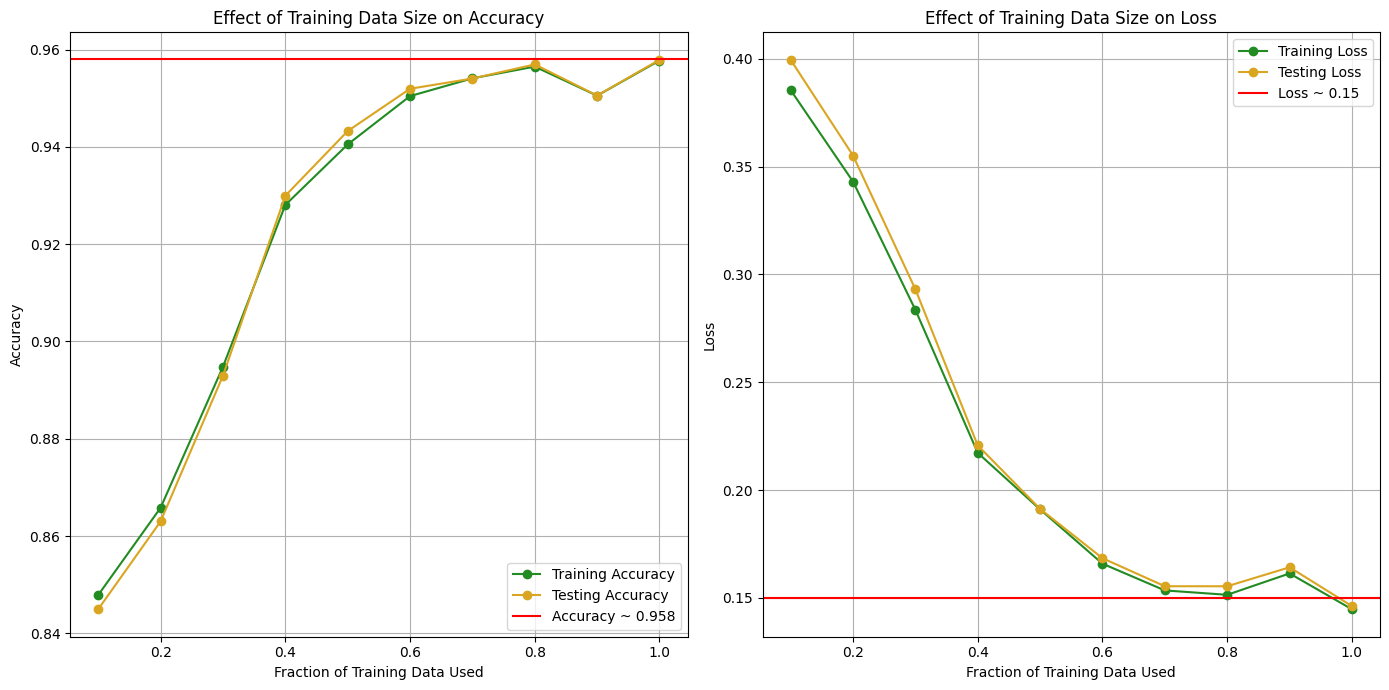

In [5]:
plt.figure(figsize = (14, 7))
plt.subplot(1, 2, 1)
plt.plot(fractions, trainAccuracy, marker = 'o', label = 'Training Accuracy', color = 'forestgreen')
plt.plot(fractions, testAccuracy, marker ='o', label = 'Testing Accuracy', color = 'goldenrod')
plt.axhline(y = 0.958, xmin = 0, xmax = epochs, linestyle= '-', color = 'r', label = "Accuracy ~ 0.958")
plt.title("Effect of Training Data Size on Accuracy")
plt.xlabel("Fraction of Training Data Used")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(fractions, trainLoss, marker = 'o', label = 'Training Loss', color = 'forestgreen')
plt.plot(fractions, testLoss, marker ='o', label = 'Testing Loss', color = 'goldenrod')
plt.axhline(y = 0.15, xmin = 0, xmax = epochs, linestyle= '-', color = 'r', label = "Loss ~ 0.15")
plt.title("Effect of Training Data Size on Loss")
plt.xlabel("Fraction of Training Data Used")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

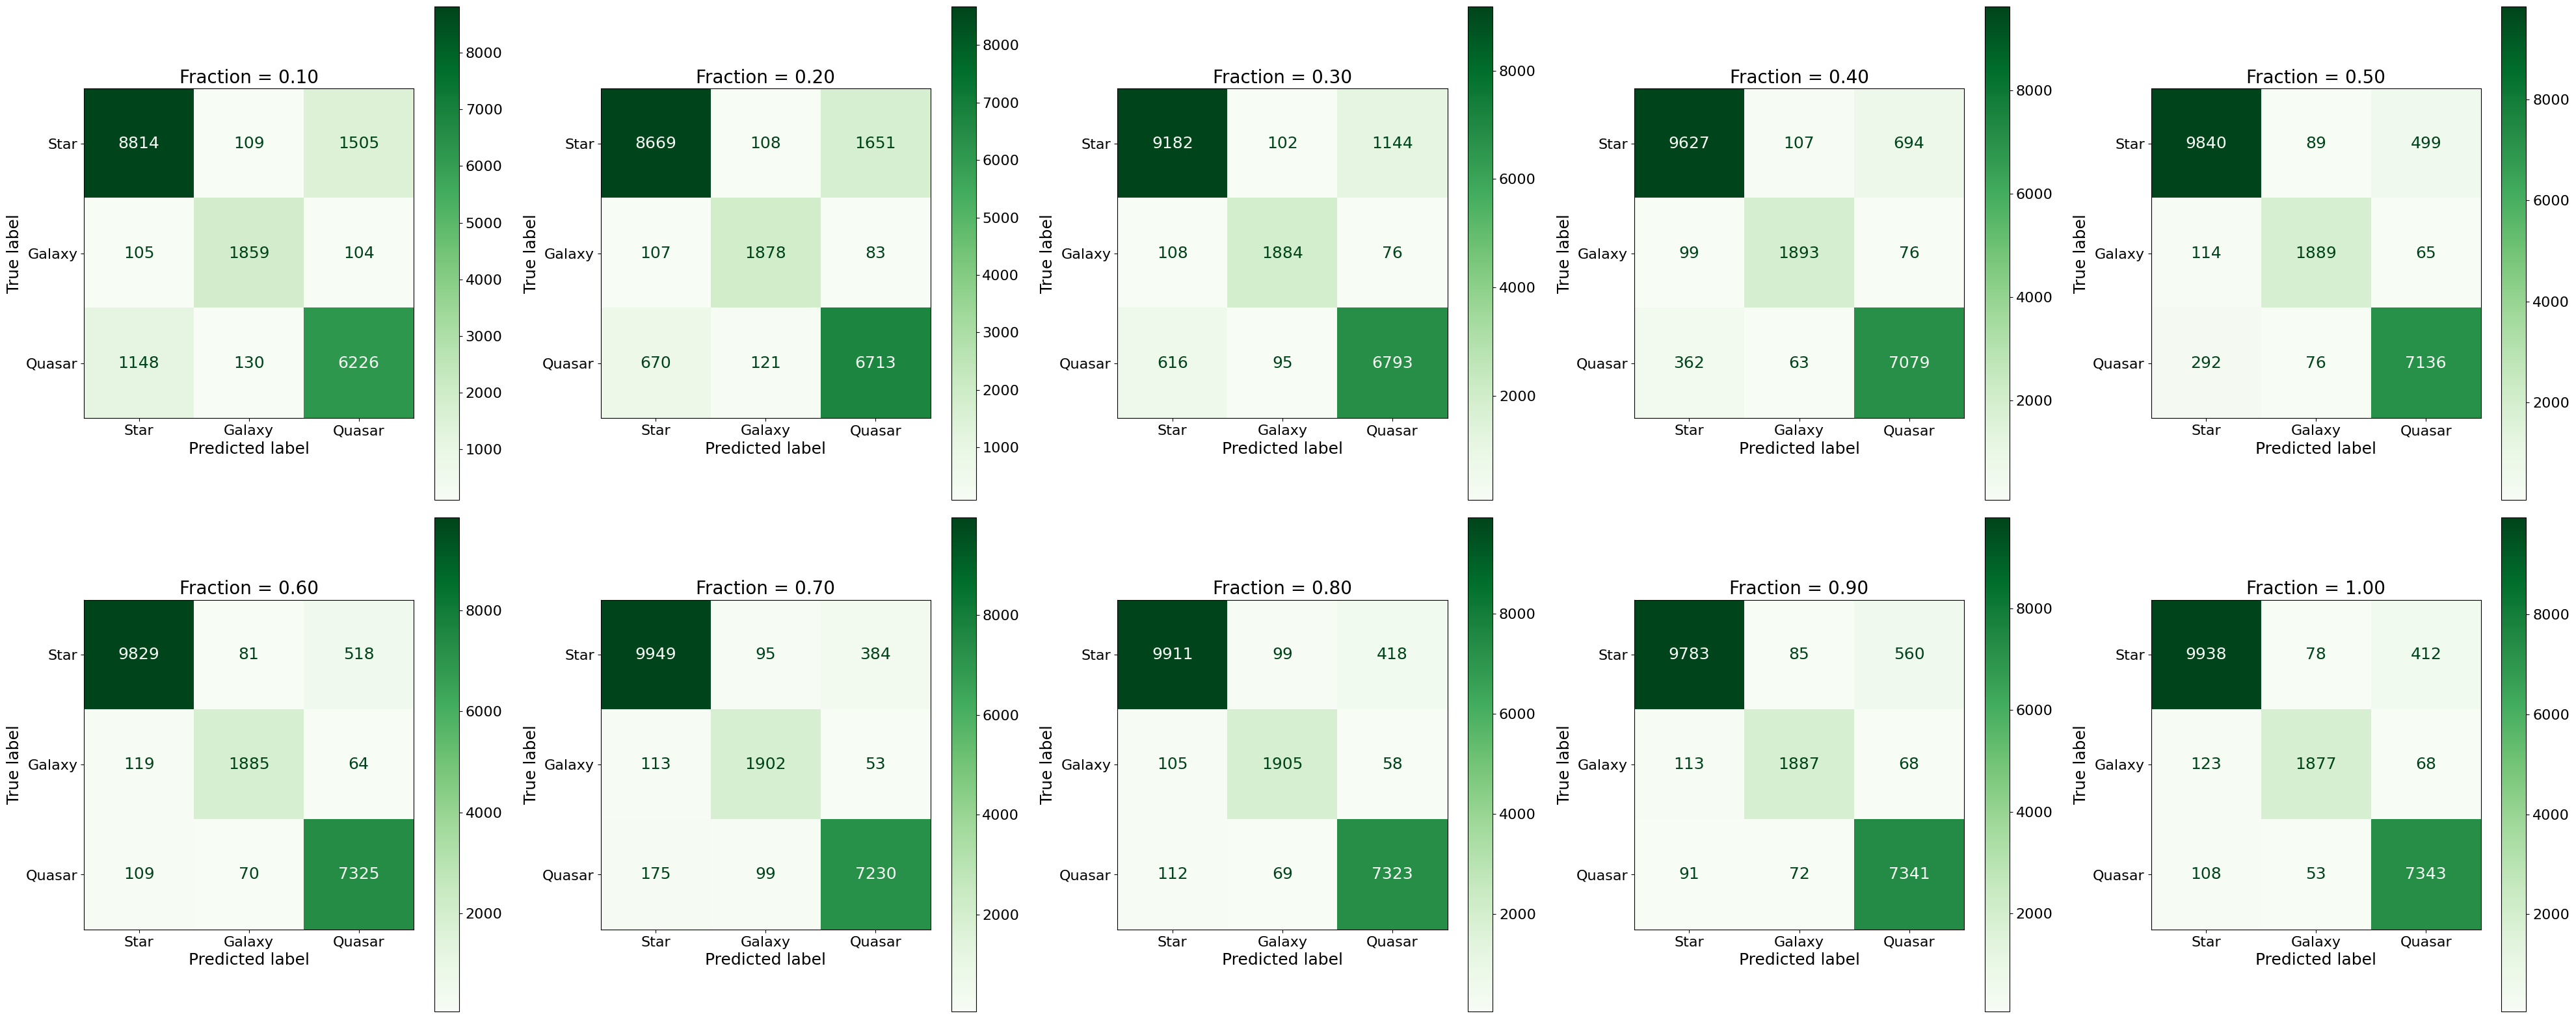

In [6]:
plt.rcParams.update({
    "font.size": 18,
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16
})

fig, axes = plt.subplots(2, 5, figsize=(40, 16))
axes = axes.flatten()

for ax, (i, confMatrix) in zip(axes, confusionMatrices):
    disp = ConfusionMatrixDisplay(
        confusion_matrix=confMatrix,
        display_labels=['Star', 'Galaxy', 'Quasar']
    )
    disp.plot(cmap="Greens", values_format="d", ax=ax, colorbar=True)
    ax.set_title(f"Fraction = {i:.2f}")

plt.tight_layout()
plt.show()

In [8]:
features = ['u', 'g', 'r', 'i', 'z'] #features we aim to target

x = data[features] #takes data from features and defines it as x
y = data['class'] #takes classes from data and defines it as y

labelEncoder = LabelEncoder() #defines encoding of target variables
yEncoded = labelEncoder.fit_transform(y) #encodes classes as Star - 0, Galaxy - 1, and Quasar - 2

scaler = StandardScaler() #defines standardisation
xScaled = scaler.fit_transform(x) #standardises x

test_size = 0.02 #defines test size
random_state = 12 #defines random state - allows for same results each time
xTrain, xTest, yTrain, yTest = dataSplitting(xScaled, yEncoded, test_size, random_state) #splits the data into a training set and a testing set

xTrainTensor = torch.tensor(xTrain, dtype = torch.float32) #converts training set to tensors
yTrainTensor = torch.tensor(yTrain, dtype = torch.long) 
xTestTensor = torch.tensor(xTest, dtype = torch.float32) #converts testing set to tensors
yTestTensor = torch.tensor(yTest, dtype = torch.long)

trainData = TensorDataset(xTrainTensor, yTrainTensor) #creates the training dataset
testData = TensorDataset(xTestTensor, yTestTensor) #creates the testing dataset
trainLoader = DataLoader(trainData, batch_size = 64, shuffle = True) #loads the training dataset, shuffle = True ensures mixing of data
testLoader =  DataLoader(testData, batch_size = 64, shuffle = False) #loads the testing dataset, shuffle = False preserves order

model = NeuralNetworkClassifier()

criteria = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr = 0.001)
epochs = 25
lossHistory = modelTraining(model, trainLoader, criteria, optimiser, epochs)

Epoch 1/25, loss = 0.600
Epoch 2/25, loss = 0.474
Epoch 3/25, loss = 0.432
Epoch 4/25, loss = 0.394
Epoch 5/25, loss = 0.352
Epoch 6/25, loss = 0.304
Epoch 7/25, loss = 0.265
Epoch 8/25, loss = 0.250
Epoch 9/25, loss = 0.226
Epoch 10/25, loss = 0.208
Epoch 11/25, loss = 0.195
Epoch 12/25, loss = 0.189
Epoch 13/25, loss = 0.179
Epoch 14/25, loss = 0.175
Epoch 15/25, loss = 0.180
Epoch 16/25, loss = 0.168
Epoch 17/25, loss = 0.169
Epoch 18/25, loss = 0.172
Epoch 19/25, loss = 0.165
Epoch 20/25, loss = 0.162
Epoch 21/25, loss = 0.160
Epoch 22/25, loss = 0.165
Epoch 23/25, loss = 0.160
Epoch 24/25, loss = 0.157
Epoch 25/25, loss = 0.158


Accuracy Score: 0.94
Classification Report:
              precision    recall  f1-score   support

      GALAXY       0.98      0.93      0.95      1105
         QSO       0.95      0.89      0.92       202
        STAR       0.89      0.99      0.94       693

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.95      0.94      0.95      2000
 



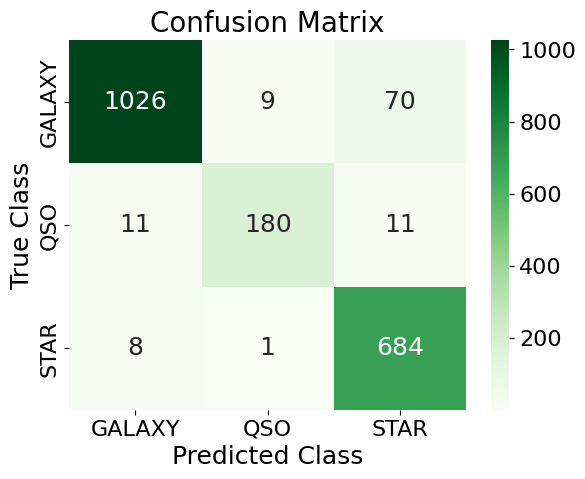

In [9]:
modelEvaluationNN(model, testLoader, labelEncoder)

## 2. Affect of balance of classes in a classification problem on a neural network ##

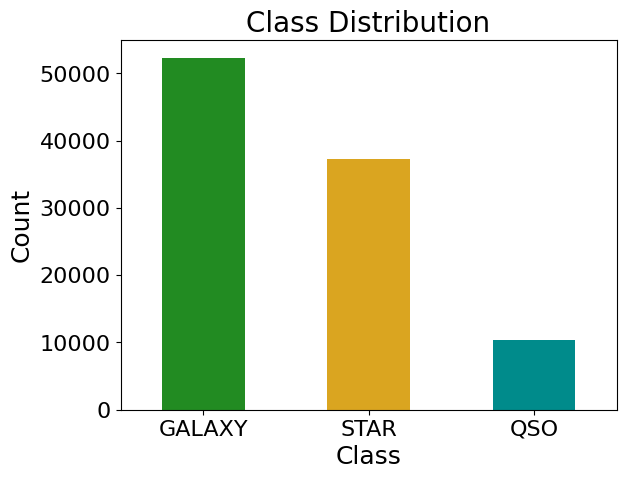

In [10]:
data['class'].value_counts().plot(kind='bar', color = ['forestgreen', 'goldenrod', 'darkcyan'])
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation = 0)
plt.show()

In [13]:
features = ['u', 'g', 'r', 'i', 'z'] #features we aim to target

x = data[features] #takes data from features and defines it as x
y = data['class'] #takes classes from data and defines it as y

labelEncoder = LabelEncoder() #defines encoding of target variables
yEncoded = labelEncoder.fit_transform(y) #encodes classes as Star - 0, Galaxy - 1, and Quasar - 2

scaler = StandardScaler() #defines standardisation
xScaled = scaler.fit_transform(x) #standardises x

test_size = 0.2 #defines test size
random_state = 12 #defines random state - allows for same results each time
xTrain, xTest, yTrain, yTest = dataSplitting(xScaled, yEncoded, test_size, random_state) #splits the data into a training set and a testing set

xTrainTensor = torch.tensor(xTrain, dtype = torch.float32) #converts training set to tensors
yTrainTensor = torch.tensor(yTrain, dtype = torch.long) 
xTestTensor = torch.tensor(xTest, dtype = torch.float32) #converts testing set to tensors
yTestTensor = torch.tensor(yTest, dtype = torch.long)

trainData = TensorDataset(xTrainTensor, yTrainTensor) #creates the training dataset
testData = TensorDataset(xTestTensor, yTestTensor) #creates the testing dataset
trainLoader = DataLoader(trainData, batch_size = 64, shuffle = True) #loads the training dataset, shuffle = True ensures mixing of data
testLoader =  DataLoader(testData, batch_size = 64, shuffle = False) #loads the testing dataset, shuffle = False preserves order

model = NeuralNetworkClassifier()

criteria = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr = 0.001)
epochs = 25
lossHistory = modelTraining(model, trainLoader, criteria, optimiser, epochs)

Epoch 1/25, loss = 0.607
Epoch 2/25, loss = 0.485
Epoch 3/25, loss = 0.435
Epoch 4/25, loss = 0.405
Epoch 5/25, loss = 0.385
Epoch 6/25, loss = 0.370
Epoch 7/25, loss = 0.331
Epoch 8/25, loss = 0.293
Epoch 9/25, loss = 0.254
Epoch 10/25, loss = 0.227
Epoch 11/25, loss = 0.208
Epoch 12/25, loss = 0.196
Epoch 13/25, loss = 0.186
Epoch 14/25, loss = 0.179
Epoch 15/25, loss = 0.173
Epoch 16/25, loss = 0.169
Epoch 17/25, loss = 0.165
Epoch 18/25, loss = 0.163
Epoch 19/25, loss = 0.161
Epoch 20/25, loss = 0.160
Epoch 21/25, loss = 0.159
Epoch 22/25, loss = 0.156
Epoch 23/25, loss = 0.158
Epoch 24/25, loss = 0.155
Epoch 25/25, loss = 0.154


Accuracy Score: 0.96
Classification Report:
              precision    recall  f1-score   support

      GALAXY       0.98      0.96      0.97     10428
         QSO       0.93      0.92      0.92      2068
        STAR       0.94      0.97      0.96      7504

    accuracy                           0.96     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.96      0.96      0.96     20000
 



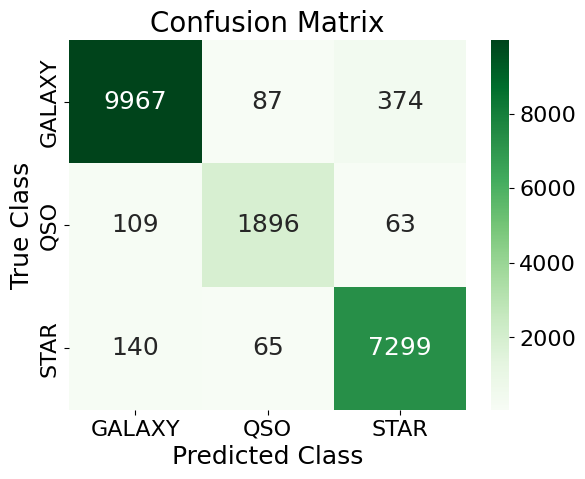

In [14]:
modelEvaluationNN(model, testLoader, labelEncoder)

In [17]:
features = ['u', 'g', 'r', 'i', 'z'] #features we aim to target

x = data[features] #takes data from features and defines it as x
y = data['class'] #takes classes from data and defines it as y

labelEncoder = LabelEncoder() #defines encoding of target variables
yEncoded = labelEncoder.fit_transform(y) #encodes classes as Star - 0, Galaxy - 1, and Quasar - 2

scaler = StandardScaler() #defines standardisation
xScaled = scaler.fit_transform(x) #standardises x

test_size = 0.2 #defines test size
random_state = 12 #defines random state - allows for same results each time
xTrain, xTest, yTrain, yTest = dataSplitting(xScaled, yEncoded, test_size, random_state) #splits the data into a training set and a testing set

starIndex = np.where(yTrain == 0)[0] #finds instances of stars
galaxyIndex = np.where(yTrain == 1)[0] #finds instances of galaxies
quasarIndex = np.where(yTrain == 2)[0] #finds instances of quasars

numStar = len(starIndex) #number of stars
numGalaxy = len(galaxyIndex) #number of galaxies
numQSO = len(quasarIndex) #numbers of quasars

numStarsSample = min(numStar, numQSO) #ensures sample is smallest
numGalaxiesSample = min(numGalaxy, numQSO)

starIndexUndersample = np.random.choice(starIndex, size = numStarsSample, replace = False)
galaxyIndexUndersample = np.random.choice(galaxyIndex, size = numGalaxiesSample, replace = False)

undersampledIndex = np.concatenate([starIndexUndersample, galaxyIndexUndersample, quasarIndex])

xTrainBalanced = xTrain[undersampledIndex]
yTrainBalanced = yTrain[undersampledIndex]

xTrainTensor = torch.tensor(xTrainBalanced, dtype = torch.float32) #converts training set to tensors
yTrainTensor = torch.tensor(yTrainBalanced, dtype = torch.long) 
xTestTensor = torch.tensor(xTest, dtype = torch.float32) #converts testing set to tensors
yTestTensor = torch.tensor(yTest, dtype = torch.long)

trainData = TensorDataset(xTrainTensor, yTrainTensor) #creates the training dataset
testData = TensorDataset(xTestTensor, yTestTensor) #creates the testing dataset
trainLoader = DataLoader(trainData, batch_size = 64, shuffle = True) #loads the training dataset, shuffle = True ensures mixing of data
testLoader =  DataLoader(testData, batch_size = 64, shuffle = False) #loads the testing dataset, shuffle = False preserves order

model = NeuralNetworkClassifier()

criteria = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr = 0.001)
epochs = 25
lossHistory = modelTraining(model, trainLoader, criteria, optimiser, epochs)

Epoch 1/25, loss = 0.654
Epoch 2/25, loss = 0.541
Epoch 3/25, loss = 0.469
Epoch 4/25, loss = 0.429
Epoch 5/25, loss = 0.399
Epoch 6/25, loss = 0.368
Epoch 7/25, loss = 0.340
Epoch 8/25, loss = 0.311
Epoch 9/25, loss = 0.289
Epoch 10/25, loss = 0.260
Epoch 11/25, loss = 0.243
Epoch 12/25, loss = 0.232
Epoch 13/25, loss = 0.220
Epoch 14/25, loss = 0.210
Epoch 15/25, loss = 0.200
Epoch 16/25, loss = 0.195
Epoch 17/25, loss = 0.188
Epoch 18/25, loss = 0.185
Epoch 19/25, loss = 0.182
Epoch 20/25, loss = 0.176
Epoch 21/25, loss = 0.176
Epoch 22/25, loss = 0.172
Epoch 23/25, loss = 0.173
Epoch 24/25, loss = 0.169
Epoch 25/25, loss = 0.165


Accuracy Score: 0.95
Classification Report:
              precision    recall  f1-score   support

      GALAXY       0.98      0.94      0.96     10428
         QSO       0.92      0.92      0.92      2068
        STAR       0.93      0.98      0.95      7504

    accuracy                           0.95     20000
   macro avg       0.94      0.95      0.94     20000
weighted avg       0.96      0.95      0.95     20000
 



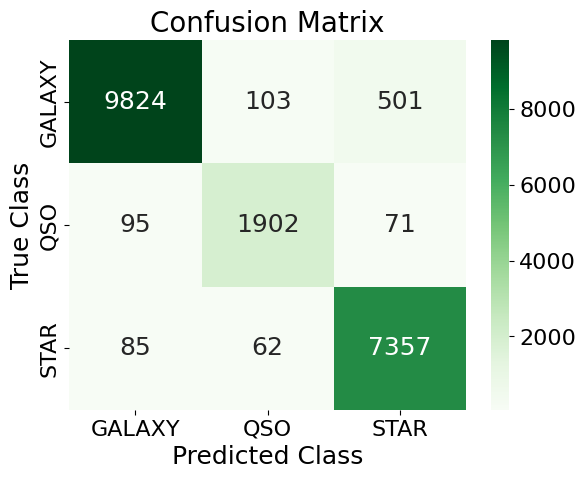

In [18]:
modelEvaluationNN(model, testLoader, labelEncoder)